In [124]:
%load_ext autoreload
%autoreload 2
INPUT_NAME = "embeddings-epoch100lr.parquet"
OUTPUT_NAME = "20250510-triplet-score-v4"
DESCRIPTION = f"{OUTPUT_NAME}, {INPUT_NAME}, k=5 on neighbors, modified z-score"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [118]:
from animalclef.spark import get_spark
from pyspark.sql import functions as F, Window
from pathlib import Path
import numpy as np
from animalclef.dataset import split_reid_data, summarize_split
import pandas as pd
import matplotlib.pyplot as plt
from functools import lru_cache
from tqdm import tqdm
import faiss
from animalclef.metrics import BAKS, BAUS
from collections import Counter


def get_min_distance_to_neighbor(train_df, k=1):
    @lru_cache(maxsize=16)
    def get_index(individual):
        """get all embeddings that do not belong to an individual. This will form
        the minimum intercluster distance."""
        sub = train_df[train_df.identity != individual]
        # Use the dimension of the embedding vectors
        embedding_dim = len(sub.embeddings.iloc[0])
        index = faiss.IndexFlatL2(embedding_dim)
        index.add(np.stack(sub.embeddings.values))
        return index

    distances = []
    # order the training set by identity so that our lru cache is more efficient
    train_df = train_df.sort_values(by="identity")
    for row in tqdm(train_df.itertuples(), total=len(train_df)):
        # get the index for the individual
        index = get_index(row.identity)
        # search for the nearest neighbor in the training set
        dist, _ = index.search(np.array([row.embeddings]), k)
        # get the average distance to the nearest neighbors
        distances.append(np.median(dist))
    return np.array(distances)


def summarize_distances(distances):
    print(f"Min distance: {distances.min()}")
    print(f"Max distance: {distances.max()}")
    print(f"Mean distance: {distances.mean()}")
    print(f"Std distance: {distances.std()}")
    # IQR
    q1 = np.percentile(distances, 25)
    q2 = np.percentile(distances, 50)
    q3 = np.percentile(distances, 75)
    iqr = q3 - q1
    print(f"IQR: {iqr}")
    print(f"Q1: {q1}")
    print(f"Q3: {q3}")
    print(f"Median: {q2}")
    mad = np.median(np.abs(distances - np.median(distances)))
    print(f"MAD: {mad}")


# def make_prediction(train_df, other_df, threshold, new_label="new_individual"):
#     # Create a FAISS index for efficient nearest neighbor search
#     X_train = np.stack(train_df.embeddings.values)
#     X_other = np.stack(other_df.embeddings.values)

#     index = faiss.IndexFlatL2(X_train.shape[1])
#     index.add(X_train)

#     dist, idx = index.search(X_other, 1)
#     predictions = train_df.iloc[idx.flatten()]["identity"].values
#     # if the distance is above a threshold, it's unknown
#     for i, v in enumerate(dist.flatten()):
#         if v > threshold:
#             predictions[i] = new_label
#     return predictions


def make_prediction(
    train_df: pd.DataFrame,
    other_df: pd.DataFrame,
    median: float,
    mad: float,
    threshold: float,
    k: int = 1,
    new_label: str = "new_individual",
) -> np.ndarray:

    X_train = np.stack(train_df.embeddings.values)
    X_other = np.stack(other_df.embeddings.values)

    index = faiss.IndexFlatL2(X_train.shape[1])
    index.add(X_train)

    dist, idx = index.search(X_other, k)

    predictions = []
    for i, (dists, ids) in enumerate(zip(dist, idx)):
        # filter ids where the distance is above the thresold
        filtered_ids = []
        for dist, id_ in zip(dists, ids):
            score = (dist - median) / (mad * 1.4826)
            if score < threshold:
                filtered_ids.append(id_)

        if len(filtered_ids) == 0:
            predictions.append(new_label)
        else:
            # get the most common identity among the k nearest neighbors
            counts = Counter(train_df.iloc[filtered_ids]["identity"].values)
            predictions.append(counts.most_common(1)[0][0])
    return np.array(predictions)


def search_threshold(train_df, other_df, median, mad, thresholds, k=1):
    identity_other_only = sorted(
        set(other_df.identity.unique()) - set(train_df.identity.unique())
    )

    scores = []
    for threshold in tqdm(thresholds):
        predictions = make_prediction(train_df, other_df, median, mad, threshold, k=k)
        baks = BAKS(other_df["identity"].values, predictions, identity_other_only)
        baus = BAUS(
            other_df["identity"].values,
            predictions,
            identity_other_only,
            "new_individual",
        )
        # geometric average
        scores.append(
            {
                "threshold": threshold,
                "baks": baks,
                "baus": baus,
                "crossover_score": 1 - abs(baks - baus),
                "score": np.sqrt(baks * baus),
            }
        )
    return pd.DataFrame(scores)


def plot_threshold_score(df, col="threshold"):
    best_score_row = df.iloc[df["score"].idxmax()]
    best_score_threshold = best_score_row[col]
    display(best_score_row.to_dict())

    best_crossover_score_row = df.iloc[df["crossover_score"].idxmax()]
    best_crossover_score_threshold = best_crossover_score_row[col]
    display(best_crossover_score_row.to_dict())

    # plot baus and baks
    plt.plot(
        df[col],
        df["baks"],
        label=f"BAKS (best {df['baks'].max():.2f})",
    )
    plt.plot(
        df[col],
        df["baus"],
        label=f"BAUS (best {df['baus'].max():.2f})",
    )
    plt.plot(
        df[col],
        df["score"],
        label=f"score (best {df["score"].max():.2f})",
    )
    # line at the best threshold
    plt.axvline(
        best_score_threshold,
        color="red",
        linestyle="--",
        label=f"best threshold: {best_score_threshold:.2f}",
    )
    plt.axvline(
        best_crossover_score_threshold,
        color="blue",
        linestyle="--",
        label=f"crossover threshold: {best_crossover_score_threshold:.2f}",
    )
    plt.xlabel("Threshold")
    plt.ylabel("Geometric mean of BAKS and BAUS")
    plt.title("Threshold vs Geometric mean of BAKS and BAUS")
    plt.legend()
    plt.show()


def experiment_threshold(train_df, val_df, num_neighbors=1):
    # get stats on the distances
    distances = get_min_distance_to_neighbor(train_df, k=num_neighbors)
    summarize_distances(distances)

    median = np.median(distances)
    mad = np.median(np.abs(distances - median))
    thresholds = np.linspace(-2, 8, 100)
    mad_threshold_df = search_threshold(
        train_df,
        val_df,
        median=median,
        mad=mad,
        thresholds=thresholds,
        k=num_neighbors,
    )
    # add k as a column
    mad_threshold_df["k"] = thresholds
    # display(mad_threshold_df)
    plot_threshold_score(mad_threshold_df, col="k")
    return mad_threshold_df

In [119]:
spark = get_spark(cores=4, memory="2g")

root = Path.home() / "scratch/animalclef"
metadata = spark.read.csv(f"{root}/raw/metadata.csv", header=True, inferSchema=True)
embeddings = spark.read.parquet(f"{root}/processed/{INPUT_NAME}")
embeddings = embeddings.select("image_id", "embeddings")
df = metadata.join(embeddings, on="image_id", how="inner").select(
    "image_id",
    "identity",
    "dataset",
    "embeddings",
    F.count("image_id").over(Window.partitionBy("identity")).alias("identity_count"),
)
df.printSchema()
pdf = df.toPandas()

# do the test split
cond = (~pdf.identity.isnull()) & (pdf.identity_count > 2)
train_df, val_df, test_df = split_reid_data(pdf[cond])
display(summarize_split(train_df, val_df, test_df))

25/05/11 05:23:42 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


root
 |-- image_id: integer (nullable = true)
 |-- identity: string (nullable = true)
 |-- dataset: string (nullable = true)
 |-- embeddings: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- identity_count: long (nullable = false)



,Split,Num Individuals,Num Images,Train Image Overlap,Val Image Overlap,Test Image Overlap,Train Image %,Val Image %,Test Image %,Known Individuals,Unknown Individuals
0,Train,404,3690,3690,0,0,100.0,0.0,0.0,404,0
1,Validation,458,2986,0,2986,0,0.0,100.0,0.0,404,54
2,Test,620,5859,0,0,5859,0.0,0.0,100.0,404,216


  4%|▍         | 147/3690 [00:00<00:02, 1443.41it/s]

100%|██████████| 3690/3690 [00:07<00:00, 510.56it/s]


Min distance: 0.5502830743789673
Max distance: 167.47604370117188
Mean distance: 13.29642105102539
Std distance: 18.7406005859375
IQR: 13.960000991821289
Q1: 3.038604259490967
Q3: 16.998605728149414
Median: 4.662092208862305
MAD: 2.200540542602539


100%|██████████| 100/100 [00:41<00:00,  2.44it/s]


{'threshold': 0.1212121212121211,
 'baks': 0.13099536848594215,
 'baus': 0.5021666543591975,
 'crossover_score': 0.6288287141267447,
 'score': 0.25647905553696937,
 'k': 0.1212121212121211}

{'threshold': 2.141414141414141,
 'baks': 0.1731353185006806,
 'baus': 0.17004477004477006,
 'crossover_score': 0.9969094515440895,
 'score': 0.1715830860576772,
 'k': 2.141414141414141}

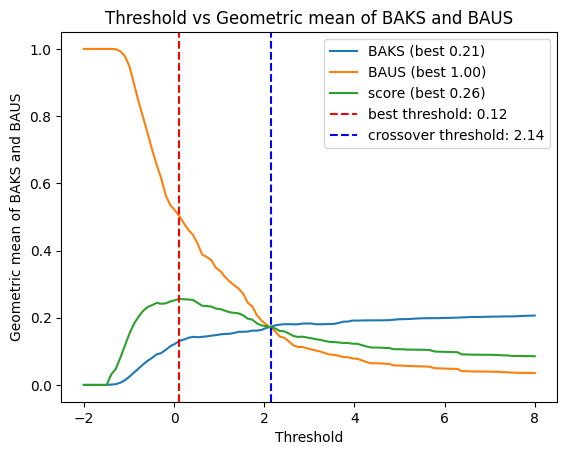

In [120]:
mad_threshold_df = experiment_threshold(train_df, val_df, num_neighbors=5)

  3%|▎         | 223/6676 [00:00<00:05, 1100.73it/s]

100%|██████████| 6676/6676 [00:14<00:00, 454.01it/s] 


Min distance: 0.34051573276519775
Max distance: 160.00758361816406
Mean distance: 11.80469799041748
Std distance: 16.593597412109375
IQR: 12.546140670776367
Q1: 2.6427698135375977
Q3: 15.188910484313965
Median: 4.071599006652832
MAD: 1.9517852067947388


100%|██████████| 100/100 [01:28<00:00,  1.13it/s]


{'threshold': -0.08080808080808088,
 'baks': 0.1285687772531083,
 'baus': 0.55891298360006,
 'crossover_score': 0.5696557936530483,
 'score': 0.2680648408358438,
 'k': -0.08080808080808088}

{'threshold': 3.2525252525252526,
 'baks': 0.199694621689396,
 'baus': 0.20097571119920027,
 'crossover_score': 0.9987189104901957,
 'score': 0.20033414241382222,
 'k': 3.2525252525252526}

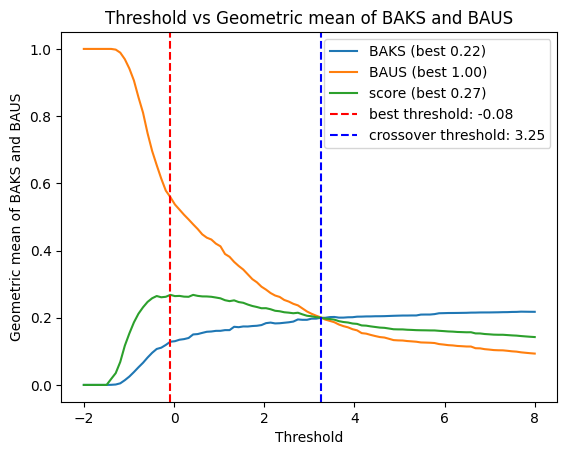

In [121]:
# retune on the test set to get a new best threshold and see if
# this improves the score
mad_threshold_df = experiment_threshold(
    pd.concat([train_df, val_df]), test_df, num_neighbors=5
)

Looks like the score increases if we include more items in the training dataset. This intuitively makes sense because we have more distances to look at.

# final prediction

In [122]:
# now for the final prediction
known_df = pdf[pdf.identity.notnull()]
unknown_df = pdf[pdf.identity.isnull()]
num_neighbors = 5

distances = get_min_distance_to_neighbor(known_df, k=num_neighbors)
median = np.median(distances)
mad = np.median(np.abs(distances - median))
best_score_threshold = mad_threshold_df["k"][mad_threshold_df["score"].idxmax()]
best_crossover_score_threshold = mad_threshold_df["k"][
    mad_threshold_df["crossover_score"].idxmax()
]
display(
    {
        "median": median,
        "mad": mad,
        "best_score_threshold": best_score_threshold,
        "best_crossover_score_threshold": best_crossover_score_threshold,
    }
)

  0%|          | 0/13074 [00:00<?, ?it/s]

100%|██████████| 13074/13074 [01:07<00:00, 192.86it/s]


{'median': np.float32(3.6607594),
 'mad': np.float32(1.9046681),
 'best_score_threshold': np.float64(-0.08080808080808088),
 'best_crossover_score_threshold': np.float64(3.2525252525252526)}

In [125]:
predictions = make_prediction(
    known_df, unknown_df, median, mad, best_score_threshold, k=num_neighbors
)
# count how many are predicted as "unknown"
display(
    {
        "unknown": len(predictions[predictions == "new_individual"]),
        "known": len(predictions[predictions != "new_individual"]),
        "total": len(predictions),
    }
)
# save this result
unknown_df["identity"] = predictions
output_path = Path.home() / f"shared/animalclef/data/predictions/{OUTPUT_NAME}.csv"
output_path.parent.mkdir(parents=True, exist_ok=True)
unknown_df[["image_id", "identity"]].to_csv(output_path, index=False, header=True)

{'unknown': 1700, 'known': 435, 'total': 2135}

/tmp/ipykernel_433671/697442948.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_df["identity"] = predictions


In [126]:
! kaggle competitions submit -c animal-clef-2025 -f {output_path} -m "{DESCRIPTION}"

100%|██████████████████████████████████████| 44.4k/44.4k [00:00<00:00, 71.6kB/s]
Successfully submitted to AnimalCLEF25 @ CVPR-FGVC & LifeCLEF